In [13]:
import numpy as np
import matplotlib as mpl
%matplotlib notebook
%pylab inline
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
#Probability libraries
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
from scipy.stats import gaussian_kde


Populating the interactive namespace from numpy and matplotlib


Use this webpage for info: https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

In [14]:
#Fitt Functions
def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


In [15]:
#Adaptative Kernel. https://github.com/cooperlab/AdaptiveKDE. http://176.32.89.45/~hideaki/res/kernel.html
def ssvkernel(x, tin=None, M=80, nbs=1e2, WinFunc='Boxcar'):
    """
    Generates a locally adaptive kernel-density estimate for one-dimensional
    data.
    The user provides a one-dimensional vector of samples drawn from some
    underlying unknown distribution, and optionally the values where they want
    to estimate the probability density of that distribution. The algorithm
    solves an optimization problem to identify variable bandwidths across the
    domain where the data is provided.
    The optimization is based on a principle of minimizing expected L2 loss
    function between the kernel estimate and an unknown underlying density
    function. An assumption is merely that samples are drawn from the density
    independently of each other.
    The locally adaptive bandwidth is obtained by iteratively computing optimal
    fixed-size bandwidths wihtihn local intervals. The optimal bandwidths are
    selected such that they are selected in the intervals that are gamma times
    larger than the optimal bandwidths themselves. The paramter gamma is
    optimized by minimizing the L2 risk estimate.
    Parameters
    ----------
    x : array_like
        The one-dimensional samples drawn from the underlying density
    tin : array_like, optional
        The values where the density estimate is to be evaluated in generating
        the output 'y'. Default value = None.
    M : int, optional
        The number of window sizes to evaluate. Default value = 80.
    nbs : int, optional
        The number of bootstrap samples to use in estimating the [0.05, 0.95]
        confidence interval of the output 'y'.
    WinFunc : string, optional
        The type of window function to use in estimating local bandwidth.
        Choose from one of 'Boxcar', 'Laplace', 'Cauchy' and 'Gauss'. Default
        value = 'Gauss'.
    Returns
    -------
    y : array_like
        The estimated density, evaluated at points t / tin.
    t : array_like
        The points where the density estimate 'y' is evaluated.
    optw : array_like
        The optimal local kernel bandwidths at 't'.
    gs : array_like
        The stiffness constants of the variables bandwidths evaluated.
    C : array_like
        Cost functions associated with stiffness constraints.
    confb95 : array_like
        The 5% and 95% confidence interval of the kernel density estimate 'y'.
        Has dimensions 2 x len(y). confb95[0,:] corresponds to the 5% interval,
        and confb95[1,:] corresponds to the 95% interval.
    yb : array_like
        The bootstrap samples used in estimating confb95. Each row corresponds
        to one bootstrap sample.
    See Also
    --------
    sshist, sskernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "Kernel Bandwidth Optimization in 
           Spike Rate Estimation," in Journal of Computational Neuroscience 
           29(1-2): 171–182, 2010 http://dx.doi.org/10.1007/s10827-009-0180-4
    """

    # set argument 't' if not provided
    if tin is None:
        T = np.max(x) - np.min(x)
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        tin = np.linspace(np.min(x), np.max(x), min(np.ceil(T / dt_samp), 1e3))
        t = tin
        x_ab = x[(x >= min(tin)) & (x <= max(tin))]
    else:
        T = np.max(x) - np.min(x)
        x_ab = x[(x >= min(tin)) & (x <= max(tin))]
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        if dt_samp > min(np.diff(tin)):
            t = np.linspace(min(tin), max(tin), min(np.ceil(T / dt_samp, 1e3)))
        else:
            t = tin

    # calculate delta t
    dt = min(np.diff(t))

    # create the finest histogram
    thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
    y_hist = np.histogram(x_ab, thist-dt/2)[0] / dt
    L = y_hist.size
    N = sum(y_hist * dt).astype(np.float)

    # initialize window sizes
    W = logexp(np.linspace(ilogexp(5 * dt), ilogexp(T), M))

    # compute local cost functions
    c = np.zeros((M, L))
    for j in range(M):
        w = W[j]
        yh = fftkernel(y_hist, w / dt)
        c[j, :] = yh**2 - 2 * yh * y_hist + 2 / (2 * np.pi)**0.5 / w * y_hist

    # initialize optimal ws
    optws = np.zeros((M, L))
    for i in range(M):
        Win = W[i]
        C_local = np.zeros((M, L))
        for j in range(M):
            C_local[j, :] = fftkernelWin(c[j, :], Win / dt, WinFunc)
        n = np.argmin(C_local, axis=0)
        optws[i, :] = W[n]

    # golden section search for stiffness parameter of variable bandwidths
    k = 0
    gs = np.zeros((30, 1))
    C = np.zeros((30, 1))
    tol = 1e-5
    a = 1e-12
    b = 1
    phi = (5**0.5 + 1) / 2
    c1 = (phi - 1) * a + (2 - phi) * b
    c2 = (2 - phi) * a + (phi - 1) * b
    f1 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c1)[0]
    f2 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c2)[0]
    while (np.abs(b-a) > tol * (abs(c1) + abs(c2))) & (k < 30):
        if f1 < f2:
            b = c2
            c2 = c1
            c1 = (phi - 1) * a + (2 - phi) * b
            f2 = f1
            f1, yv1, optwp1 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c1)
            yopt = yv1 / np.sum(yv1 * dt)
            optw = optwp1
        else:
            a = c1
            c1 = c2
            c2 = (2 - phi) * a + (phi - 1) * b
            f1 = f2
            f2, yv2, optwp2 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c2)
            yopt = yv2 / np.sum(yv2 * dt)
            optw = optwp2

        # capture estimates and increment iteration counter
        gs[k] = c1
        C[k] = f1
        k = k + 1

    # discard unused entries in gs, C
    gs = gs[0:k]
    C = C[0:k]

    # estimate confidence intervals by bootstrapping
    nbs = np.asarray(nbs)
    yb = np.zeros((nbs, tin.size))
    for i in range(nbs):
        Nb = np.random.poisson(lam=N)
        idx = np.random.randint(0, N, Nb)
        xb = x_ab[idx]
        thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
        y_histb = np.histogram(xb, thist - dt / 2)[0]
        idx = y_histb.nonzero()
        y_histb_nz = y_histb[idx]
        t_nz = t[idx]
        yb_buf = np.zeros((L, ))
        for k in range(L):
            yb_buf[k] = np.sum(y_histb_nz * Gauss(t[k] - t_nz, optw[k])) / Nb
        yb_buf = yb_buf / np.sum(yb_buf * dt)
        yb[i, :] = np.interp(tin, t, yb_buf)
    ybsort = np.sort(yb, axis=0)
    y95b = ybsort[np.floor(0.05 * nbs), :]
    y95u = ybsort[np.floor(0.95 * nbs), :]
    confb95 = np.concatenate((y95b[np.newaxis], y95u[np.newaxis]), axis=0)

    # return outputs
    y = np.interp(tin, t, yopt)
    optw = np.interp(tin, t, optw)
    t = tin

    return y, t, optw, gs, C, confb95, yb


def CostFunction(y_hist, N, t, dt, optws, WIN, WinFunc, g):

    L = y_hist.size
    optwv = np.zeros((L, ))
    for k in range(L):
        gs = optws[:, k] / WIN
        if g > np.max(gs):
            optwv[k] = np.min(WIN)
        else:
            if g < min(gs):
                optwv[k] = np.max(WIN)
            else:
                idx = np.max(np.nonzero(gs >= g))
                optwv[k] = g * WIN[idx]

    # Nadaraya-Watson kernel regression
    optwp = np.zeros((L, ))
    for k in range(L):
        if WinFunc == 'Boxcar':
            Z = Boxcar(t[k]-t, optwv / g)
        elif WinFunc == 'Laplace':
            Z = Laplace(t[k]-t, optwv / g)
        elif WinFunc == 'Cauchy':
            Z = Cauchy(t[k]-t, optwv / g)
        else:  # WinFunc == 'Gauss'
            Z = Gauss(t[k]-t, optwv / g)
        optwp[k] = np.sum(optwv * Z) / np.sum(Z)

    # speed-optimized baloon estimator
    idx = y_hist.nonzero()
    y_hist_nz = y_hist[idx]
    t_nz = t[idx]
    yv = np.zeros((L, ))
    for k in range(L):
        yv[k] = np.sum(y_hist_nz * dt * Gauss(t[k]-t_nz, optwp[k]))
    yv = yv * N / np.sum(yv * dt)

    # cost function of estimated kernel
    cg = yv**2 - 2 * yv * y_hist + 2 / (2 * np.pi)**0.5 / optwp * y_hist
    Cg = np.sum(cg * dt)

    return Cg, yv, optwp


def fftkernel(x, w):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: n / 2 + 1],
                        f[1: n / 2 - 1 + 1][::-1]))

    # evaluate kernel
    K = np.exp(-0.5 * (w * 2 * np.pi * f) ** 2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def fftkernelWin(x, w, WinFunc):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: n / 2 + 1],
                        f[1: n / 2 - 1 + 1][::-1]))
    t = 2 * np.pi * f

    # determine window function - evaluate kernel
    if WinFunc == 'Boxcar':
        a = 12**0.5 * w
        K = 2 * np.sin(a * t / 2) / (a * t)
        K[0] = 1
    elif WinFunc == 'Laplace':
        K = 1 / (1 + (w * 2 * np.pi * f)**2 / 2)
    elif WinFunc == 'Cauchy':
        K = np.exp(-w * np.abs(2 * np.pi * f))
    else:  # WinFunc == 'Gauss'
        K = np.exp(-0.5 * (w * 2 * np.pi * f)**2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def Gauss(x, w):
    y = 1 / (2 * np.pi)**2 / w * np.exp(-x**2 / 2 / w**2)
    return y


def Laplace(x, w):
    y = 1 / 2**0.5 / w * np.exp(-(2**0.5) / w / np.abs(x))
    return y


def Cauchy(x, w):
    y = 1 / (np.pi * w * (1 + (x / w)**2))
    return y


def Boxcar(x, w):
    a = 12**0.5 * w
    y = 1 / a
    y[np.abs(x) > a / 2] = 0
    return y


def logexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(1+np.exp(x[x < 1e2]))
    y[x >= 1e2] = x[x >= 1e2]
    return y


def ilogexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(np.exp(x[x < 1e2]) - 1)
    y[x >= 1e2] = x[x >= 1e2]
    return y


In [16]:
#Loading Data
#Oligocene-Lower Miocene DZ
Hist1=np.loadtxt("Andes(Oli-EarlyMio).txt")
#Middle Miocene-Pliocene DZ
Hist2=np.loadtxt("Andes(MMio-Pliocene).txt")
#Ecuador Signature
EcuadorH1=np.loadtxt("Ecuador (EarlyMiddMio).txt") #La muestra mas joven
EcuadorH2=np.loadtxt("Ecuador (OliEarlyMi).txt") #Todos menos la muestra mas joven
EcuadorH3=np.loadtxt("Ecuador (OliEarMio).txt") #Todos los datos juntos
#Cauca Signature
#10 Ma and 2 Ma
LaPaila=np.loadtxt("Zarzal.txt") #Datos La Paila Fm.
Zarzal=np.loadtxt("LaPaila.txt") #Datos Zarsal Fm.
#Upper Miocene-Pliocene (Tumaco)
Tumaco1=np.loadtxt("Tumaco(Pliocene).txt")
#Lower-Middle Miocene (Tumaco)
Tumaco2=np.loadtxt("Tumaco(middleMiocene).txt")
#Middle-Upper Miocene (Cauca-Patia)
Patia1=np.loadtxt("CanalBasin (Oligocene-Lower Miocene).txt")
#Lower Miocene (Cauca-Patia)
Patia2=np.loadtxt("CaucaPatia(LowerMiocene).txt")

In [17]:
#Loading Data
#Data to Compare
Intrusives=np.loadtxt("PanamaIntrusives.txt")
ModernSediments=np.loadtxt("PModernSediments.txt")
PanamaData=np.loadtxt("PanamaData.txt")

In [18]:
#Operations
Hist1C=[]
Hist1NC=[]
Hist2C=[]
Hist2NC=[]
EcuadorH3C=[]
EcuadorH3NC=[]
PanamaC=[]
PanamaNC=[]
Hist2P=[]
Hist2NP=[]
# DZ with Cenozoic age (Oligocene-Lower Miocene, Andes)
for i in range (0,len(Hist1)):
    if Hist1[i]<=66:
        Hist1C.append(Hist1[i])
    else:
    #Other DZ
        Hist1NC.append(Hist1[i])
    
# DZ with Panamanian signature (Middle Miocene-Pliocene, Andes)
for i in range (0,len(Hist2)):
    if Hist2[i]<=40 and Hist2[i]>=30:
        Hist2P.append(Hist2[i])
    else:
    #Other DZ
        Hist2NP.append(Hist2[i])    
        
# DZ with Cenozoic age (Oligocene-Lower Miocene, Ecuador)
for i in range (0,len(EcuadorH3)):
    if EcuadorH3[i]<=66:
        EcuadorH3C.append(EcuadorH3[i])
    else:
    #Other DZ
        EcuadorH3NC.append(EcuadorH3[i])
        
# DZ with Cenozoic age (Oligocene-Lower Miocene, Panama)
for i in range (0,len(PanamaData)):
    if PanamaData[i]<=66:
        PanamaC.append(PanamaData[i])
    else:
    #Other DZ
        PanamaNC.append(PanamaData[i])

In [19]:
# DZ with Cenozoic age (Middle Miocene,Andes)
for i in range (0,len(Hist2)):
    if Hist2[i]<=66:
        Hist2C.append(Hist2[i])
    else:
    #Other DZ
        Hist2NC.append(Hist2[i])


# Histogramas

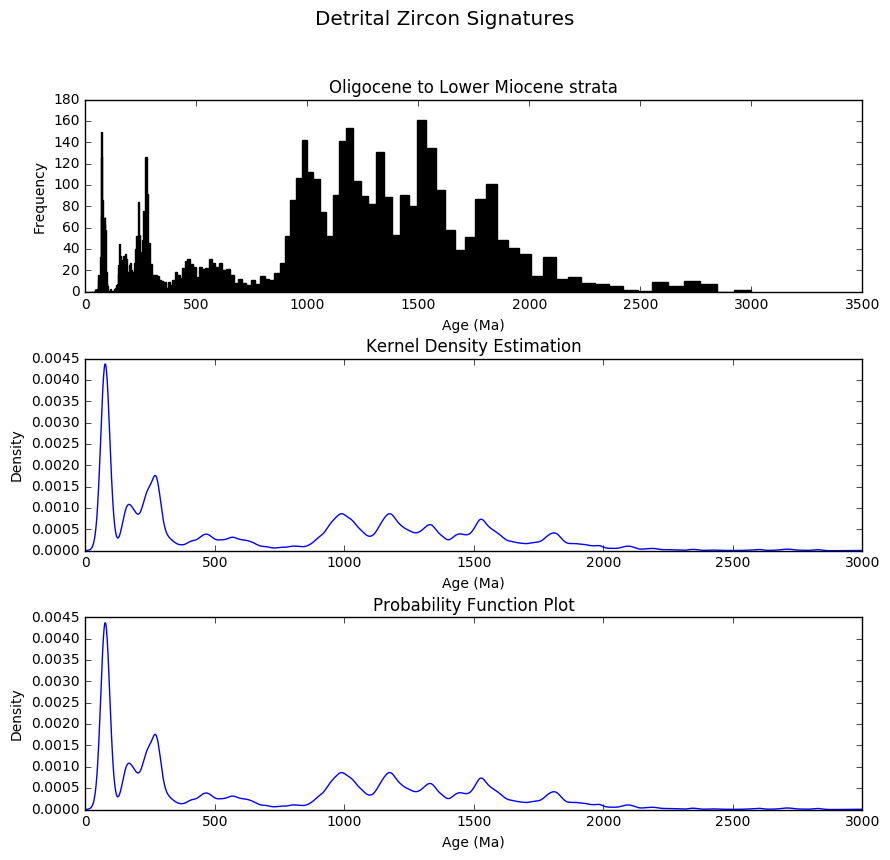

In [20]:
#Histograma 1
F1=figure(1, figsize=(9, 9))
st=F1.suptitle("Detrital Zircon Signatures",fontsize="x-large")

sF1=F1.add_subplot(311)
hist(Hist1, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='black')
#gca().set_xscale("log")
#gca().set_yscale("log")
#gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
xlabel("Age (Ma)")
ylabel("Frequency")
sF1.set_title("Oligocene to Lower Miocene strata")

#Kernel Estimation
sF2=F1.add_subplot(312)
x1_grid=linspace(1,3000,2000)


plot(x1_grid,kde_sklearn(Hist1,x1_grid,bandwidth=15))
#gca().set_xscale("log")
#gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
xlabel("Age (Ma)")
ylabel("Density")
sF2.set_title("Kernel Density Estimation")

#Probability density estomation
sF3=F1.add_subplot(313)
plot(x1_grid,kde_scipy(Hist1,x1_grid,bandwidth=15))
#gca().set_xscale("log")
#gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
xlabel("Age (Ma)")
ylabel("Density")
sF3.set_title("Probability Function Plot")

F1.tight_layout()
st.set_y(0.95)
F1.subplots_adjust(top=0.85)

savefig('DZ_Oligocene_Lower Miocene.png')


In [21]:
#Best bandwidth

#Oligocene-Lower Miocene
grid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1, 15, 50)},cv=20) # 20-fold cross-validation
grid.fit(Hist1[:, None])
print grid.best_params_

#Middle Miocene-Pliocene
grid1 = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.1, 15, 50)},cv=20) # 20-fold cross-validation
grid1.fit(Hist2[:, None])
print grid1.best_params_

{'bandwidth': 15.0}
{'bandwidth': 7.3979591836734686}


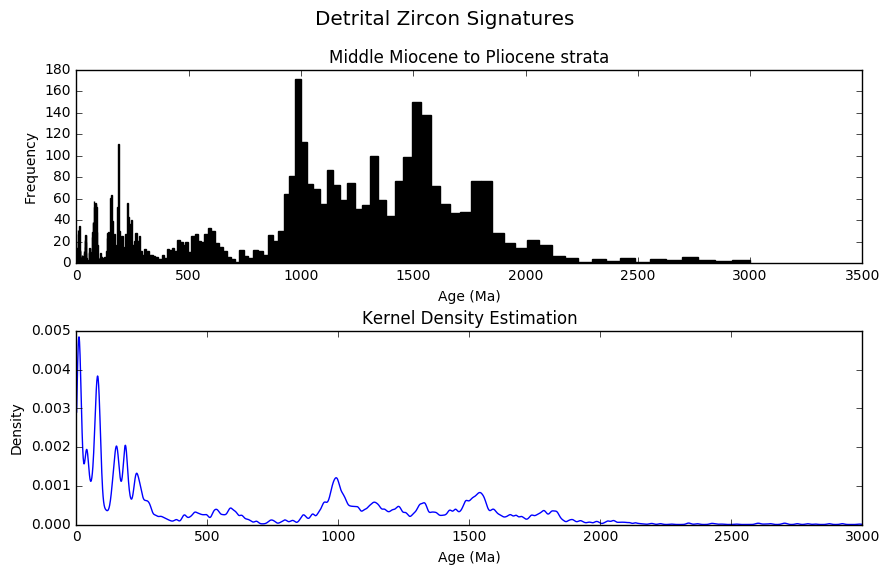

In [22]:
#Histograma 2
F2=figure(2, figsize=(9,6))
st=F2.suptitle("Detrital Zircon Signatures",fontsize="x-large")
x1_grid=linspace(1,3000,3000)

sF1=F2.add_subplot(211)
hist(Hist2, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='black')
#gca().set_xscale("log")
#gca().set_yscale("log")
#gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
sF1.set_title("Middle Miocene to Pliocene strata")
xlabel("Age (Ma)")
ylabel("Frequency")

sF2=F2.add_subplot(212)
plot(x1_grid,kde_scipy(Hist2,x1_grid,bandwidth=7.4))
#gca().set_xscale("log")
#gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
sF2.set_title("Kernel Density Estimation")

xlabel("Age (Ma)")
ylabel("Density")

F2.tight_layout()
st.set_y(0.95)
F2.subplots_adjust(top=0.85)


savefig('DZ_Middle Miocene_Pliocene.png')

<IPython.core.display.Javascript object>


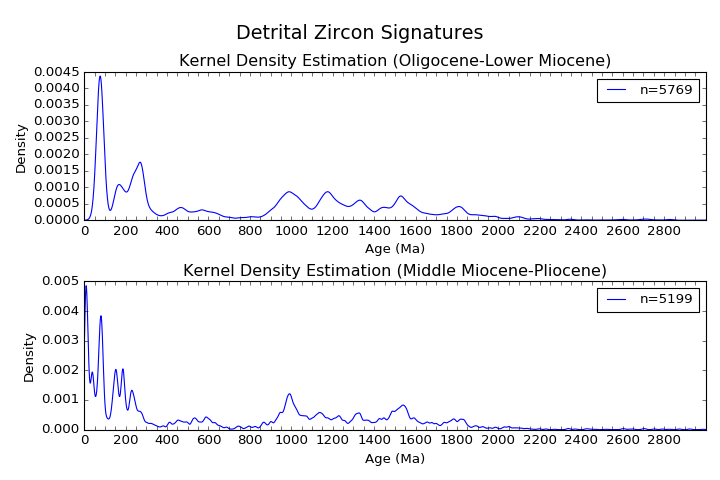

In [34]:
#Comparison distributions
%matplotlib notebook
%matplotlib notebook
import matplotlib.pyplot as plt

F3=figure(2, figsize=(9,6))
st=F3.suptitle("Detrital Zircon Signatures",fontsize="x-large")
x1_grid=linspace(1,3000,3000)
x2_grid=linspace(1,3000,3000)

sF1=F3.add_subplot(211)
plot(x1_grid,kde_sklearn(Hist1,x1_grid,bandwidth=15),label='n={0}'.format(len(Hist1)))
#gca().set_xscale("log")
#gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
xlabel("Age (Ma)")
ylabel("Density")
gca().xaxis.set_ticks(np.arange(0, 3000, 50))
counter=0
reset=0
for i in range (0, 3000, 50):
    if reset!=0:  
        xticks = gca().xaxis.get_major_ticks()
        xticks[counter].label1.set_visible(False)
    counter=counter+1
    reset=reset+1
    if reset==4:
        reset=0
        
sF1.set_title("Kernel Density Estimation (Oligocene-Lower Miocene)")
legend(loc='upper right',fontsize = 'medium')

sF2=F3.add_subplot(212)
plot(x2_grid,kde_sklearn(Hist2,x2_grid,bandwidth=7.4),label='n={0}'.format(len(Hist2)))
#gca().set_xscale("log")
#gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
sF2.set_title("Kernel Density Estimation (Middle Miocene-Pliocene)")
xlabel("Age (Ma)")
ylabel("Density")
gca().xaxis.set_ticks(np.arange(0, 3000, 50))
counter=0
reset=0
for i in range (0, 3000, 50):
    if reset!=0:  
        xticks = gca().xaxis.get_major_ticks()
        xticks[counter].label1.set_visible(False)
    counter=counter+1
    reset=reset+1
    if reset==4:
        reset=0
legend(loc='upper right',fontsize = 'medium')

F3.tight_layout()
st.set_y(0.95)
F3.subplots_adjust(top=0.85)


#savefig('DZ_Kernel Density.png')

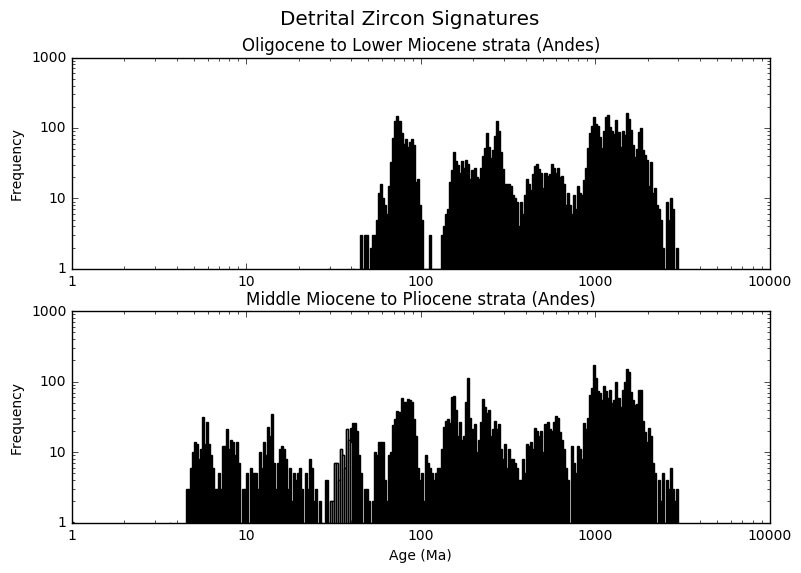

In [24]:
#Comparison

fig5=figure(5, figsize=(9,6))
st=fig5.suptitle("Detrital Zircon Signatures",fontsize="x-large")


s1=fig5.add_subplot(211)
hist(Hist1, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='black')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s1.set_title("Oligocene to Lower Miocene strata (Andes)")
ylabel("Frequency")

s2=fig5.add_subplot(212)
hist(Hist2, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='black')
hist(Hist2P, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='cyan')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s2.set_title("Middle Miocene to Pliocene strata (Andes)")
ylabel("Frequency")

xlabel("Age (Ma)")

savefig('DZ_Oligocene-Pliocene(Andes).png')



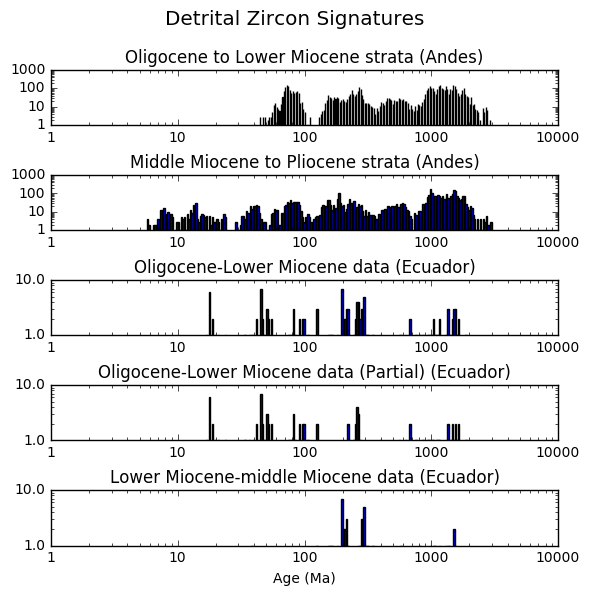

In [29]:
fig5=figure(5, figsize=(6,6))
st=fig5.suptitle("Detrital Zircon Signatures",fontsize="x-large")

s1=fig5.add_subplot(511)
hist(Hist1, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),width=0.1,color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s1.set_title("Oligocene to Lower Miocene strata (Andes)")

s2=fig5.add_subplot(512)
hist(Hist2, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s2.set_title("Middle Miocene to Pliocene strata (Andes)")

s3=fig5.add_subplot(513)
hist(EcuadorH3, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s3.set_title("Oligocene-Lower Miocene data (Ecuador)")

s4=fig5.add_subplot(514)
hist(EcuadorH2, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s4.set_title("Oligocene-Lower Miocene data (Partial) (Ecuador)")

s5=fig5.add_subplot(515)
hist(EcuadorH1, bins = 10 ** np.linspace(np.log10(1), np.log10(3000), 300),color='blue')
gca().set_xscale("log")
gca().set_yscale("log")
gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
s5.set_title("Lower Miocene-middle Miocene data (Ecuador)")

fig5.tight_layout()
st.set_y(0.95)
fig5.subplots_adjust(top=0.85)
xlabel("Age (Ma)")

savefig('DZ_Andes_Ecuador.png')

# Whisk & Whisker Plots



In [30]:
# OB=Oriente Basin
#PB-PR=Panama basins-Rivers(Canal, Cobachon, Modern Rivers=PanamaData.txt)
#NAR1=Northern Andes (Oligocene-Lower Miocene)
#NAR2= Northern Andes (Middle Miocene-Pliocene)

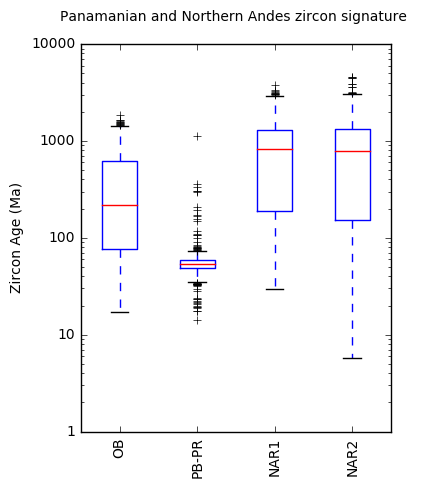

In [31]:
#Diagrama 1
data1=[EcuadorH3,PanamaData,Hist1,Hist2]
fig1=figure(3, figsize=(4, 5))
ax1=fig1.add_subplot(111)
gca().set_yscale("log")
gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
box1=ax1.boxplot(data1)
title("Panamanian and Northern Andes zircon signature \n",size=10)
ax1.set_xticklabels(['OB','PB-PR','NAR1','NAR2'],rotation='vertical')
ylabel("Zircon Age (Ma)")
savefig('DZ_NAndes_Panama_Whisker(full signature).png')

In [32]:
#Kolmogorov–Smirnov test
#Northern Andes strata- (Oligocene-Lower Miocene & Middle Miocene-Pliocene)
stats.ks_2samp(Hist2, Hist1)

Ks_2sampResult(statistic=0.1130299263656924, pvalue=7.600787302295685e-29)

Distribution of Oligocene-Lower Miocene cant be the same that Middle Miocene-Pliocene in Northern Andes Data.Very Low P-value and not small D value.

In [33]:
#Kolmogorov–Smirnov test
#Northern Andes strata- (Oligocene-Lower Miocene & Panama detrital zircon data)
stats.ks_2samp(PanamaData,Hist1)

Ks_2sampResult(statistic=0.89705418676517179, pvalue=3.061578892489466e-304)

Distribution of Oligocene-Lower Miocene cant be the same distribution of Oligocene-Lower Miocene data reported in Panamanian strata. Very Low p-value and high D value.

In [34]:
#Kolmogorov–Smirnov test
#Northern Andes strata- (Middle Miocene-Pliocene & Panama detrital zircon data)
stats.ks_2samp(PanamaData,Hist2)

Ks_2sampResult(statistic=0.79689553219448095, pvalue=1.3346160417857752e-235)

Distribution of Oligocene-Lower Miocene cant be the same distribution of Oligocene-Lower Miocene data reported in Panamanian strata. Very Low p-value and high D value.

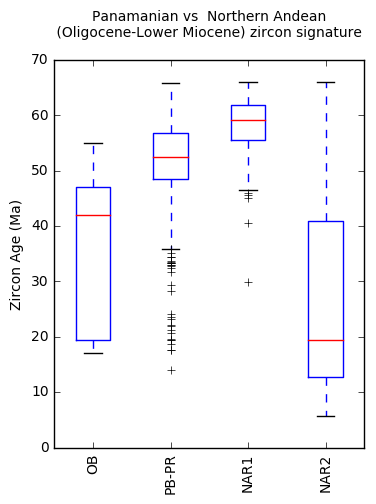

In [35]:
data1=[EcuadorH3C,PanamaC,Hist1C,Hist2C]
fig1=figure(3, figsize=(4, 5))
ax1=fig1.add_subplot(111)
ylim(0,70)
box1=ax1.boxplot(data1)
title("Panamanian vs  Northern Andean\n (Oligocene-Lower Miocene) zircon signature \n",size=10)
ax1.set_xticklabels(['OB','PB-PR','NAR1','NAR2'],rotation='vertical')
ylabel("Zircon Age (Ma)")
savefig('DZ_NAndes_Panama_Whisker(Cenozoic signature).png')


In [36]:
#Northern Andes strata- (Oligocene-Lower Miocene & Panama strata)
stats.ks_2samp(PanamaData,Hist1C)

Ks_2sampResult(statistic=0.40613590263691685, pvalue=4.81967804152209e-11)

Distribution of Oligocene-Lower Miocene cant be the same that Middle Miocene-Pliocene in Northern Andes Data.Very Low P-value and not small D value.

In [37]:
#Northern Andes strata- (Middle Miocene-Pliocene & Panama strata)
stats.ks_2samp(PanamaData,Hist2C)

Ks_2sampResult(statistic=0.74733349493970058, pvalue=2.1829605404552406e-126)

Distribution of Middle Miocene-Pliocene cant be the same that Middle Miocene-Pliocene in Northern Andes Data.Very Low P-value and not small D value. However, this can be related to a major proportion of Oligocene-Upper Miocene DZ ages over Eocene DZ.

In [38]:
len(Hist1)

5769

In [39]:
len(Hist2)

4566